## Training

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [2]:
class GestureDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.FloatTensor(sequences)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [ ]:
class GestureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(GestureLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the last output
        out = out[:, -1, :]
        
        # Fully connected layers
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

class RPSGestureClassifier:
    def __init__(self, sequence_length=15):
        self.sequence_length = sequence_length
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.mp_drawing = mp.solutions.drawing_utils
        self.label_encoder = LabelEncoder()
        self.model = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
    def extract_landmarks_from_video(self, video_path):
        """Extract hand landmarks from a video file"""
        cap = cv2.VideoCapture(video_path)
        landmarks_sequence = []
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            # Convert BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Process frame
            results = self.hands.process(rgb_frame)
            
            if results.multi_hand_landmarks:
                # Get first hand landmarks
                hand_landmarks = results.multi_hand_landmarks[0]
                
                # Extract x, y, z coordinates
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                
                landmarks_sequence.append(landmarks)
            else:
                # If no hand detected, use previous frame or zeros
                if landmarks_sequence:
                    landmarks_sequence.append(landmarks_sequence[-1])
                else:
                    landmarks_sequence.append([0.0] * 63)  # 21 landmarks * 3 coordinates
        
        cap.release()
        return np.array(landmarks_sequence)
    
    def normalize_landmarks(self, landmarks):
        """Normalize landmarks relative to wrist position"""
        if len(landmarks) == 0:
            return landmarks
            
        normalized = landmarks.copy()
        
        for i in range(len(landmarks)):
            if np.sum(landmarks[i]) == 0:  # Skip zero frames
                continue
                
            # Reshape to get individual landmarks
            frame_landmarks = landmarks[i].reshape(21, 3)
            
            # Get wrist position (landmark 0)
            wrist = frame_landmarks[0]
            
            # Subtract wrist position from all landmarks
            frame_landmarks = frame_landmarks - wrist
            
            # Calculate hand size (distance from wrist to middle finger tip)
            hand_size = np.linalg.norm(frame_landmarks[12])  # Middle finger tip
            
            # Normalize by hand size (avoid division by zero)
            if hand_size > 0:
                frame_landmarks = frame_landmarks / hand_size
            
            normalized[i] = frame_landmarks.flatten()
        
        return normalized
    
    def create_sequences(self, landmarks, label):
        """Create fixed-length sequences from landmark data"""
        sequences = []
        labels = []
        
        if len(landmarks) < self.sequence_length:
            # If video is too short, pad with last frame
            padding = [landmarks[-1]] * (self.sequence_length - len(landmarks))
            landmarks = np.vstack([landmarks, padding])
        
        # Create overlapping sequences
        for i in range(len(landmarks) - self.sequence_length + 1):
            sequence = landmarks[i:i + self.sequence_length]
            sequences.append(sequence)
            labels.append(label)
        
        return np.array(sequences), np.array(labels)
    
    def process_video_dataset(self, video_dir):
        """Process all videos in a directory structure"""
        all_sequences = []
        all_labels = []
        
        # Expected directory structure: video_dir/gesture_name/video_files
        gesture_dirs = [d for d in os.listdir(video_dir) if os.path.isdir(os.path.join(video_dir, d))]
        
        for gesture_name in gesture_dirs:
            gesture_path = os.path.join(video_dir, gesture_name)
            video_files = [f for f in os.listdir(gesture_path) if f.endswith(('.mp4', '.avi', '.mov'))]
            
            print(f"Processing {len(video_files)} videos for gesture: {gesture_name}")
            
            for video_file in video_files:
                video_path = os.path.join(gesture_path, video_file)
                
                # Extract landmarks
                landmarks = self.extract_landmarks_from_video(video_path)
                
                if len(landmarks) > 0:
                    # Normalize landmarks
                    normalized_landmarks = self.normalize_landmarks(landmarks)
                    
                    # Create sequences
                    sequences, labels = self.create_sequences(normalized_landmarks, gesture_name)
                    
                    all_sequences.extend(sequences)
                    all_labels.extend(labels)
        
        return np.array(all_sequences), np.array(all_labels)
    
    def train(self, video_dir, test_size=0.2, epochs=50, batch_size=32, learning_rate=0.001):
        """Train the gesture classification model"""
        print("Processing video dataset...")
        X, y = self.process_video_dataset(video_dir)
        
        print(f"Total sequences: {len(X)}")
        print(f"Sequence shape: {X.shape}")
        print(f"Unique labels: {np.unique(y)}")
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
        )
        
        print(f"Training samples: {len(X_train)}")
        print(f"Testing samples: {len(X_test)}")
        
        # Create datasets and dataloaders
        train_dataset = GestureDataset(X_train, y_train)
        test_dataset = GestureDataset(X_test, y_test)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        input_size = 63  # 21 landmarks * 3 coordinates
        hidden_size = 64
        num_layers = 2
        num_classes = len(np.unique(y_encoded))
        
        self.model = GestureLSTM(input_size, hidden_size, num_layers, num_classes)
        self.model.to(self.device)
        
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # Training history
        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []
        
        print("Starting training...")
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            correct_train = 0
            total_train = 0
            
            for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                sequences, labels = sequences.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(sequences)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
            
            # Validation phase
            self.model.eval()
            test_loss = 0.0
            correct_test = 0
            total_test = 0
            
            with torch.no_grad():
                for sequences, labels in test_loader:
                    sequences, labels = sequences.to(self.device), labels.to(self.device)
                    outputs = self.model(sequences)
                    loss = criterion(outputs, labels)
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()
            
            # Calculate metrics
            train_loss /= len(train_loader)
            test_loss /= len(test_loader)
            train_acc = 100 * correct_train / total_train
            test_acc = 100 * correct_test / total_test
            
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
            print("-" * 50)
        
        # Plot training history
        self.plot_training_history(train_losses, train_accuracies, test_losses, test_accuracies)
        
        print(f"Final Test Accuracy: {test_acc:.2f}%")
        
        return {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'test_losses': test_losses,
            'test_accuracies': test_accuracies
        }
    
    def plot_training_history(self, train_losses, train_accuracies, test_losses, test_accuracies):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot losses
        ax1.plot(train_losses, label='Training Loss')
        ax1.plot(test_losses, label='Test Loss')
        ax1.set_title('LSTM Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Plot accuracies
        ax2.plot(train_accuracies, label='Training Accuracy')
        ax2.plot(test_accuracies, label='Test Accuracy')
        ax2.set_title('LSTM Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    def predict_video(self, video_path):
        """Predict gesture from a video file"""
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
        
        landmarks = self.extract_landmarks_from_video(video_path)
        
        if len(landmarks) == 0:
            return None, 0.0
        
        normalized_landmarks = self.normalize_landmarks(landmarks)
        
        # Create sequences for prediction
        sequences, _ = self.create_sequences(normalized_landmarks, "dummy")
        
        if len(sequences) == 0:
            return None, 0.0
        
        # Convert to tensor
        sequences_tensor = torch.FloatTensor(sequences).to(self.device)
        
        # Predict
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(sequences_tensor)
            probabilities = torch.softmax(outputs, dim=1)
        
        # Average predictions across all sequences
        avg_prediction = torch.mean(probabilities, dim=0).cpu().numpy()
        
        # Get predicted class and confidence
        predicted_class_idx = np.argmax(avg_prediction)
        confidence = avg_prediction[predicted_class_idx]
        
        predicted_gesture = self.label_encoder.inverse_transform([predicted_class_idx])[0]
        
        return predicted_gesture, confidence
    
    def save_model(self, model_path):
        """Save the trained model and label encoder"""
        if self.model is None:
            raise ValueError("No model to save. Train the model first.")
        
        # Save model state dict
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'model_params': {
                'input_size': 63,
                'hidden_size': 64,
                'num_layers': 2,
                'num_classes': len(self.label_encoder.classes_),
                'dropout': 0.2
            }
        }, f"{model_path}.pth")
        
        # Save label encoder
        with open(f"{model_path}_label_encoder.pkl", 'wb') as f:
            pickle.dump(self.label_encoder, f)
        
        print(f"Model saved to {model_path}.pth")
    
    def load_model(self, model_path):
        """Load a trained model and label encoder"""
        # Load model checkpoint
        checkpoint = torch.load(f"{model_path}.pth", map_location=self.device)
        
        # Initialize model with saved parameters
        params = checkpoint['model_params']
        self.model = GestureLSTM(
            params['input_size'],
            params['hidden_size'],
            params['num_layers'],
            params['num_classes'],
            params['dropout']
        )
        
        # Load model state
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()
        
        # Load label encoder
        with open(f"{model_path}_label_encoder.pkl", 'rb') as f:
            self.label_encoder = pickle.load(f)
        
        print(f"Model loaded from {model_path}.pth")


I0000 00:00:1753123757.046398  371615 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
W0000 00:00:1753123757.053124  428925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753123757.057717  428927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Using device: cpu
Processing video dataset...
Processing 45 videos for gesture: paper
Processing 45 videos for gesture: rock
Processing 45 videos for gesture: scissors
Total sequences: 6068
Sequence shape: (6068, 15, 63)
Unique labels: ['paper' 'rock' 'scissors']
Training samples: 4854
Testing samples: 1214
Starting training...


Epoch 1/35: 100%|██████████| 304/304 [00:01<00:00, 269.97it/s]


Epoch 1/35
Train Loss: 0.8243, Train Acc: 62.32%
Test Loss: 0.6519, Test Acc: 69.93%
--------------------------------------------------


Epoch 2/35: 100%|██████████| 304/304 [00:01<00:00, 267.62it/s]


Epoch 2/35
Train Loss: 0.5797, Train Acc: 75.65%
Test Loss: 0.4783, Test Acc: 81.55%
--------------------------------------------------


Epoch 3/35: 100%|██████████| 304/304 [00:01<00:00, 264.09it/s]


Epoch 3/35
Train Loss: 0.5025, Train Acc: 79.09%
Test Loss: 0.4458, Test Acc: 82.45%
--------------------------------------------------


Epoch 4/35: 100%|██████████| 304/304 [00:01<00:00, 267.21it/s]


Epoch 4/35
Train Loss: 0.4830, Train Acc: 80.55%
Test Loss: 0.4743, Test Acc: 81.38%
--------------------------------------------------


Epoch 5/35: 100%|██████████| 304/304 [00:01<00:00, 265.64it/s]


Epoch 5/35
Train Loss: 0.4404, Train Acc: 81.99%
Test Loss: 0.4331, Test Acc: 82.29%
--------------------------------------------------


Epoch 6/35: 100%|██████████| 304/304 [00:01<00:00, 268.00it/s]


Epoch 6/35
Train Loss: 0.4135, Train Acc: 83.54%
Test Loss: 0.4052, Test Acc: 82.21%
--------------------------------------------------


Epoch 7/35: 100%|██████████| 304/304 [00:01<00:00, 261.30it/s]


Epoch 7/35
Train Loss: 0.3963, Train Acc: 83.72%
Test Loss: 0.3760, Test Acc: 85.01%
--------------------------------------------------


Epoch 8/35: 100%|██████████| 304/304 [00:01<00:00, 264.78it/s]


Epoch 8/35
Train Loss: 0.3915, Train Acc: 83.85%
Test Loss: 0.4141, Test Acc: 82.78%
--------------------------------------------------


Epoch 9/35: 100%|██████████| 304/304 [00:01<00:00, 264.53it/s]


Epoch 9/35
Train Loss: 0.3735, Train Acc: 84.75%
Test Loss: 0.3374, Test Acc: 85.83%
--------------------------------------------------


Epoch 10/35: 100%|██████████| 304/304 [00:01<00:00, 260.72it/s]


Epoch 10/35
Train Loss: 0.3327, Train Acc: 85.99%
Test Loss: 0.3273, Test Acc: 86.41%
--------------------------------------------------


Epoch 11/35: 100%|██████████| 304/304 [00:01<00:00, 262.67it/s]


Epoch 11/35
Train Loss: 0.3129, Train Acc: 86.71%
Test Loss: 0.2947, Test Acc: 86.99%
--------------------------------------------------


Epoch 12/35: 100%|██████████| 304/304 [00:01<00:00, 263.60it/s]


Epoch 12/35
Train Loss: 0.2822, Train Acc: 88.38%
Test Loss: 0.3367, Test Acc: 87.15%
--------------------------------------------------


Epoch 13/35: 100%|██████████| 304/304 [00:01<00:00, 260.33it/s]


Epoch 13/35
Train Loss: 0.2948, Train Acc: 88.03%
Test Loss: 0.2750, Test Acc: 88.96%
--------------------------------------------------


Epoch 14/35: 100%|██████████| 304/304 [00:01<00:00, 262.49it/s]


Epoch 14/35
Train Loss: 0.2665, Train Acc: 89.16%
Test Loss: 0.3333, Test Acc: 85.91%
--------------------------------------------------


Epoch 15/35: 100%|██████████| 304/304 [00:01<00:00, 262.82it/s]


Epoch 15/35
Train Loss: 0.2371, Train Acc: 90.50%
Test Loss: 0.2701, Test Acc: 90.53%
--------------------------------------------------


Epoch 16/35: 100%|██████████| 304/304 [00:01<00:00, 262.52it/s]


Epoch 16/35
Train Loss: 0.2354, Train Acc: 90.46%
Test Loss: 0.3127, Test Acc: 89.29%
--------------------------------------------------


Epoch 17/35: 100%|██████████| 304/304 [00:01<00:00, 258.70it/s]


Epoch 17/35
Train Loss: 0.2321, Train Acc: 90.91%
Test Loss: 0.2334, Test Acc: 92.17%
--------------------------------------------------


Epoch 18/35: 100%|██████████| 304/304 [00:01<00:00, 262.03it/s]


Epoch 18/35
Train Loss: 0.1872, Train Acc: 92.91%
Test Loss: 0.2115, Test Acc: 91.27%
--------------------------------------------------


Epoch 19/35: 100%|██████████| 304/304 [00:01<00:00, 261.41it/s]


Epoch 19/35
Train Loss: 0.2230, Train Acc: 91.39%
Test Loss: 0.2406, Test Acc: 91.10%
--------------------------------------------------


Epoch 20/35: 100%|██████████| 304/304 [00:01<00:00, 258.46it/s]


Epoch 20/35
Train Loss: 0.1742, Train Acc: 92.89%
Test Loss: 0.1870, Test Acc: 93.66%
--------------------------------------------------


Epoch 21/35: 100%|██████████| 304/304 [00:01<00:00, 261.33it/s]


Epoch 21/35
Train Loss: 0.1767, Train Acc: 93.26%
Test Loss: 0.2082, Test Acc: 91.93%
--------------------------------------------------


Epoch 22/35: 100%|██████████| 304/304 [00:01<00:00, 260.89it/s]


Epoch 22/35
Train Loss: 0.1632, Train Acc: 93.68%
Test Loss: 0.1960, Test Acc: 92.50%
--------------------------------------------------


Epoch 23/35: 100%|██████████| 304/304 [00:01<00:00, 257.13it/s]


Epoch 23/35
Train Loss: 0.1492, Train Acc: 94.21%
Test Loss: 0.1417, Test Acc: 94.48%
--------------------------------------------------


Epoch 24/35: 100%|██████████| 304/304 [00:01<00:00, 260.62it/s]


Epoch 24/35
Train Loss: 0.1582, Train Acc: 94.09%
Test Loss: 0.1943, Test Acc: 92.67%
--------------------------------------------------


Epoch 25/35: 100%|██████████| 304/304 [00:01<00:00, 259.90it/s]


Epoch 25/35
Train Loss: 0.1440, Train Acc: 94.71%
Test Loss: 0.1996, Test Acc: 92.83%
--------------------------------------------------


Epoch 26/35: 100%|██████████| 304/304 [00:01<00:00, 256.22it/s]


Epoch 26/35
Train Loss: 0.1766, Train Acc: 93.88%
Test Loss: 0.1699, Test Acc: 93.66%
--------------------------------------------------


Epoch 27/35: 100%|██████████| 304/304 [00:01<00:00, 259.92it/s]


Epoch 27/35
Train Loss: 0.1370, Train Acc: 95.04%
Test Loss: 0.1151, Test Acc: 95.80%
--------------------------------------------------


Epoch 28/35: 100%|██████████| 304/304 [00:01<00:00, 259.98it/s]


Epoch 28/35
Train Loss: 0.1156, Train Acc: 95.59%
Test Loss: 0.1476, Test Acc: 95.30%
--------------------------------------------------


Epoch 29/35: 100%|██████████| 304/304 [00:01<00:00, 259.58it/s]


Epoch 29/35
Train Loss: 0.1088, Train Acc: 95.90%
Test Loss: 0.1421, Test Acc: 95.80%
--------------------------------------------------


Epoch 30/35: 100%|██████████| 304/304 [00:01<00:00, 255.84it/s]


Epoch 30/35
Train Loss: 0.1541, Train Acc: 95.01%
Test Loss: 0.1040, Test Acc: 96.62%
--------------------------------------------------


Epoch 31/35: 100%|██████████| 304/304 [00:01<00:00, 259.81it/s]


Epoch 31/35
Train Loss: 0.1082, Train Acc: 96.17%
Test Loss: 0.1076, Test Acc: 96.71%
--------------------------------------------------


Epoch 32/35: 100%|██████████| 304/304 [00:01<00:00, 258.64it/s]


Epoch 32/35
Train Loss: 0.1057, Train Acc: 96.17%
Test Loss: 0.1129, Test Acc: 96.54%
--------------------------------------------------


Epoch 33/35: 100%|██████████| 304/304 [00:01<00:00, 256.75it/s]


Epoch 33/35
Train Loss: 0.1128, Train Acc: 96.17%
Test Loss: 0.1299, Test Acc: 95.47%
--------------------------------------------------


Epoch 34/35: 100%|██████████| 304/304 [00:01<00:00, 258.89it/s]


Epoch 34/35
Train Loss: 0.1297, Train Acc: 95.53%
Test Loss: 0.1325, Test Acc: 95.22%
--------------------------------------------------


Epoch 35/35: 100%|██████████| 304/304 [00:01<00:00, 258.36it/s]


Epoch 35/35
Train Loss: 0.1152, Train Acc: 95.76%
Test Loss: 0.1009, Test Acc: 97.12%
--------------------------------------------------


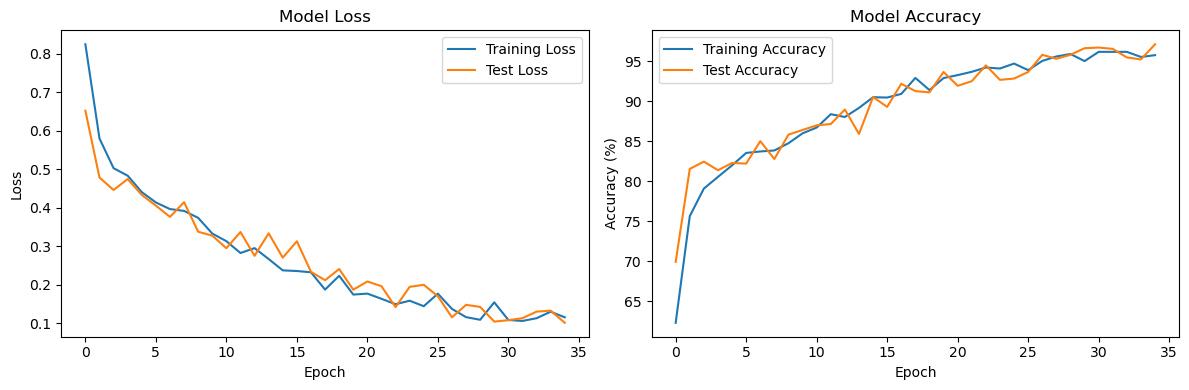

Final Test Accuracy: 97.12%
Model saved to rps_model_lstm.pth


In [ ]:
#########
# TRAIN #
#########

video_directory = "/Users/christina/code/RockPaperScissors/my_rps_dataset/data"
classifier = RPSGestureClassifier(sequence_length=15)
history = classifier.train(video_directory, epochs=35, batch_size=16)
classifier.save_model("rps_model_lstm")


In [10]:
    
    # Uncomment to load existing model
    classifier.load_model("rps_model")
    
    # Test prediction on a single video
    gesture, confidence = classifier.predict_video("/Users/christina/code/RockPaperScissors/my_rps_dataset/data/scissors/scissors_36.avi")
    print(f"Predicted gesture: {gesture} (confidence: {confidence:.2f})")

/opt/anaconda3/envs/cs587_env/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model loaded from rps_model.pth
Predicted gesture: scissors (confidence: 0.85)
